In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_tile, scale_fill_gradient, theme, element_text, labs, scale_fill_gradient2, element_blank
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from group_lasso import GroupLasso
from scipy import stats
from sklearn.metrics import r2_score
import scipy.stats as stats

Arjun

In [2]:
# ! pip install group-lasso

In [3]:
orig_df=pd.read_csv('data/CarPrice_Assignment.csv')
arjun_df=orig_df.copy()

In [4]:
len(arjun_df)

205

In [5]:
arjun_df['drivewheel'].value_counts()

drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64

In [6]:
arjun_df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [7]:
fuel = [1 if a == "gas" else 0 for a in arjun_df['fueltype']]
aspiration = [1 if b == "std" else 0 for b in arjun_df['aspiration']]
doornum = [4 if c == "four" else 2 for c in arjun_df['doornumber']]
engloc = [1 if d == "front" else 0 for d in arjun_df['enginelocation']]
arjun_df['fueltype'] = fuel
arjun_df['aspiration'] = aspiration
arjun_df['enginelocation'] = engloc
arjun_df['doornumber'] = doornum

arjun_df['CarName'].unique()

arjun_df['volume'] = arjun_df['carwidth'] * arjun_df['carheight'] * arjun_df['carlength']
arjun_df['volume'][1], arjun_df['carwidth'][1], arjun_df['carheight'][1], arjun_df['carlength'][1]

arjun_df['brand'] = [x.split(" ")[0] for x in arjun_df['CarName']]
arjun_df = arjun_df.drop(columns=['carbody'])

#filtering out 3 clynder and twelve cylnder

In [8]:
arjun_df['citympg'].head()

0    21
1    21
2    19
3    24
4    18
Name: citympg, dtype: int64

In [9]:
# fix car names
new_brands = {'maxda': 'mazda', 'Nissan':'nissan', 'porcshce':'porsche', 'toyouta':'toyota', 'vokswagen': 'volkswagen', 'vw': 'volkswagen'}
for i in range(len(arjun_df)):
  x = arjun_df['brand'][i]
  if x in new_brands:
    arjun_df['brand'][i] = new_brands[x]

# remove 12 and 3 cyclinder observations (only 1 each)
arjun_df=arjun_df[~arjun_df['cylindernumber'].isin(['twelve','three'])] 

# remove the observation 17 (high influence)
arjun_df=arjun_df.drop(16)

/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/2880289210.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/2880289210.py:6: SettingWithCopyWarning: 
A value 

In [10]:
# feauture engineer the countries
country_dict = {
    'alfa-romero': 'Italy',
    'audi': 'Germany',
    'bmw': 'Germany',
    'chevrolet': 'USA',
    'dodge': 'USA',
    'honda': 'Japan',
    'isuzu': 'Japan',
    'jaguar': 'UK',
    'mazda': 'Japan',
    'buick': 'USA',
    'mercury': 'USA',
    'mitsubishi': 'Japan',
    'nissan': 'Japan',
    'peugeot': 'France',
    'plymouth': 'USA',
    'porsche': 'Germany',
    'renault': 'France',
    'saab': 'Sweden',
    'subaru': 'Japan',
    'toyota': 'Japan',
    'volkswagen': 'Germany',
    'volvo': 'Sweden'
}

arjun_df['country'] = [country_dict[x] for x in arjun_df['brand']]

In [11]:
arjun_df['cylindernumber'].unique()

array(['four', 'six', 'five', 'two', 'eight'], dtype=object)

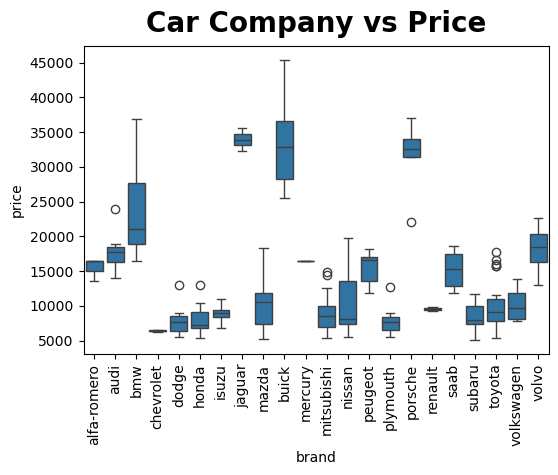

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x="brand",y="price",data=arjun_df)
plt.xticks(rotation=90)
plt.title("Car Company vs Price", pad=10, fontweight="black", fontsize=20)
plt.show()

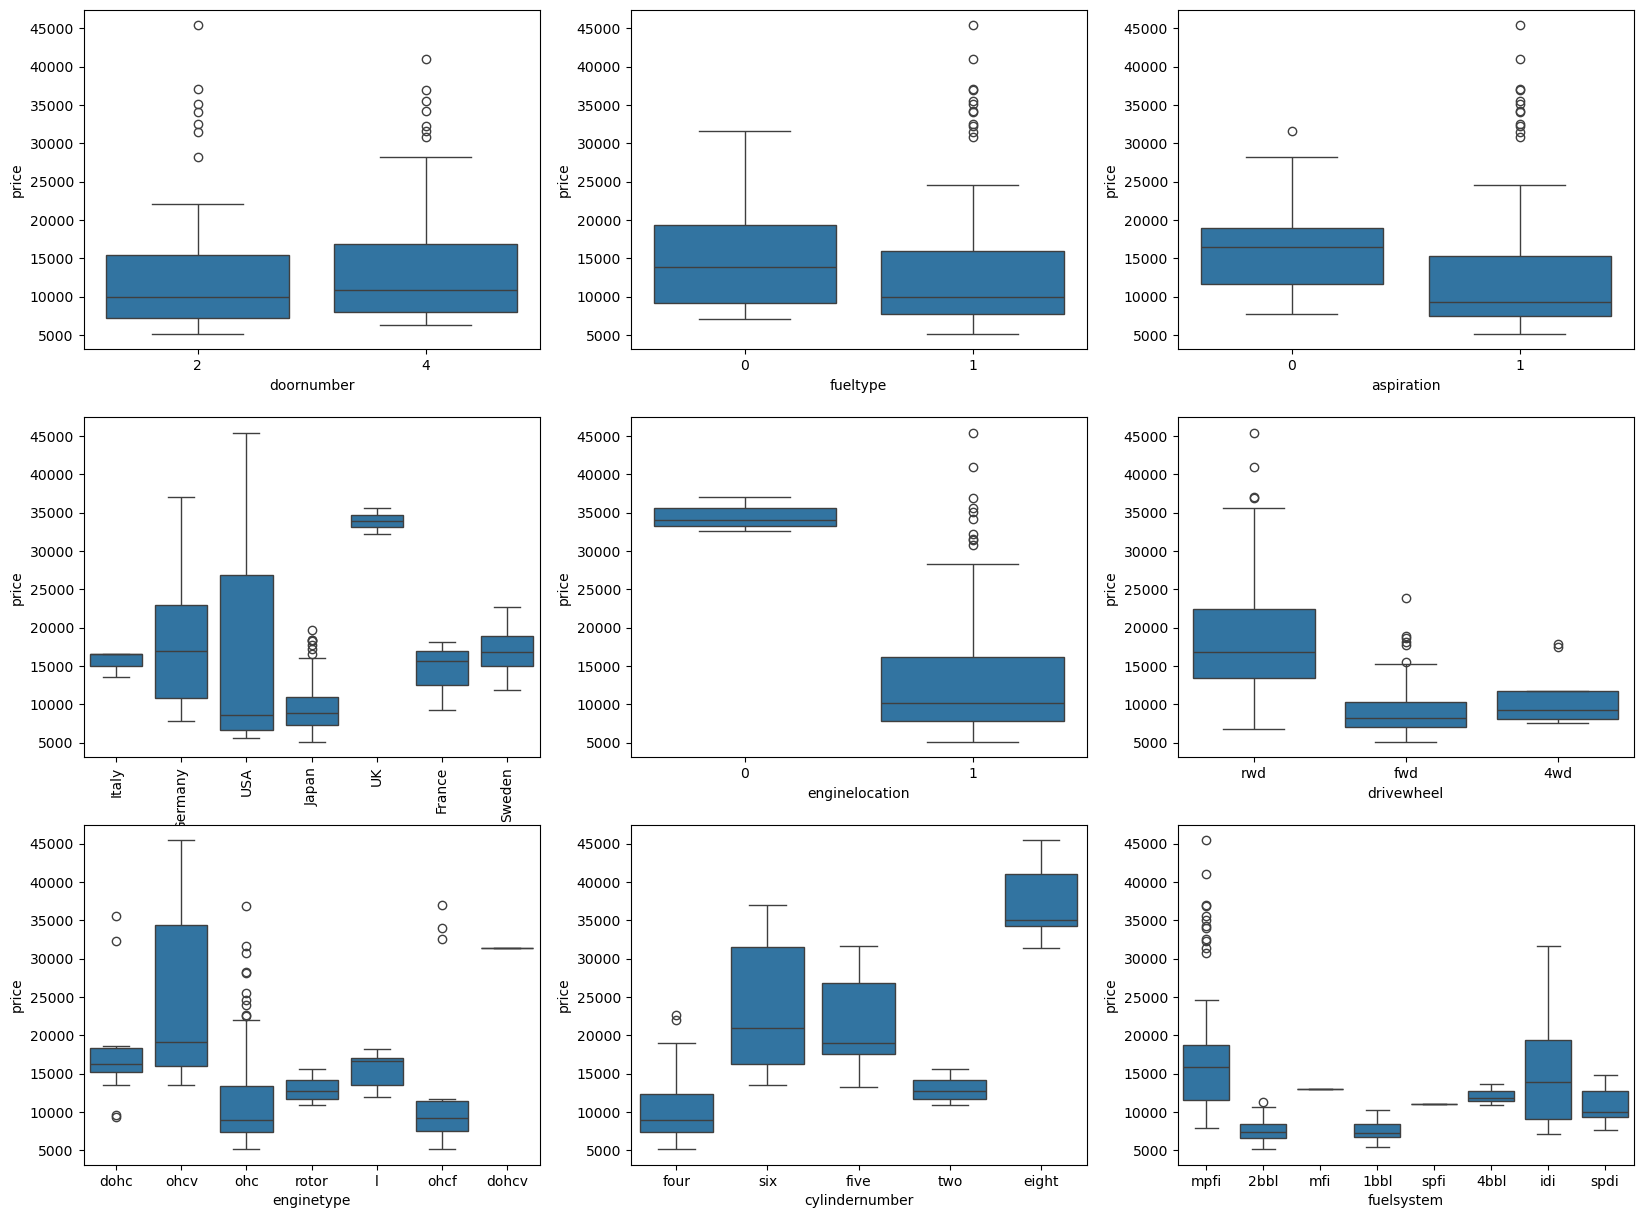

In [13]:
plt.figure(figsize=(20, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'doornumber', y = 'price', data = arjun_df)
plt.subplot(3,3,2)
sns.boxplot(x = 'fueltype', y = 'price', data = arjun_df)
plt.subplot(3,3,3)
sns.boxplot(x = 'aspiration', y = 'price', data = arjun_df)
plt.subplot(3,3,4)
sns.boxplot(x="country",y="price",data=arjun_df)
plt.xticks(rotation=90)
plt.subplot(3,3,5)
# sns.boxplot(x = 'carbody', y = 'price', data = arjun_df)
# plt.subplot(3,3,5)
sns.boxplot(x = 'enginelocation', y = 'price', data = arjun_df)
plt.subplot(3,3,6)
sns.boxplot(x = 'drivewheel', y = 'price', data = arjun_df)
plt.subplot(3,3,7)
sns.boxplot(x = 'enginetype', y = 'price', data = arjun_df)
plt.subplot(3,3,8)
sns.boxplot(x = 'cylindernumber', y = 'price', data = arjun_df)
plt.subplot(3,3,9)
sns.boxplot(x = 'fuelsystem', y = 'price', data = arjun_df)
plt.show()

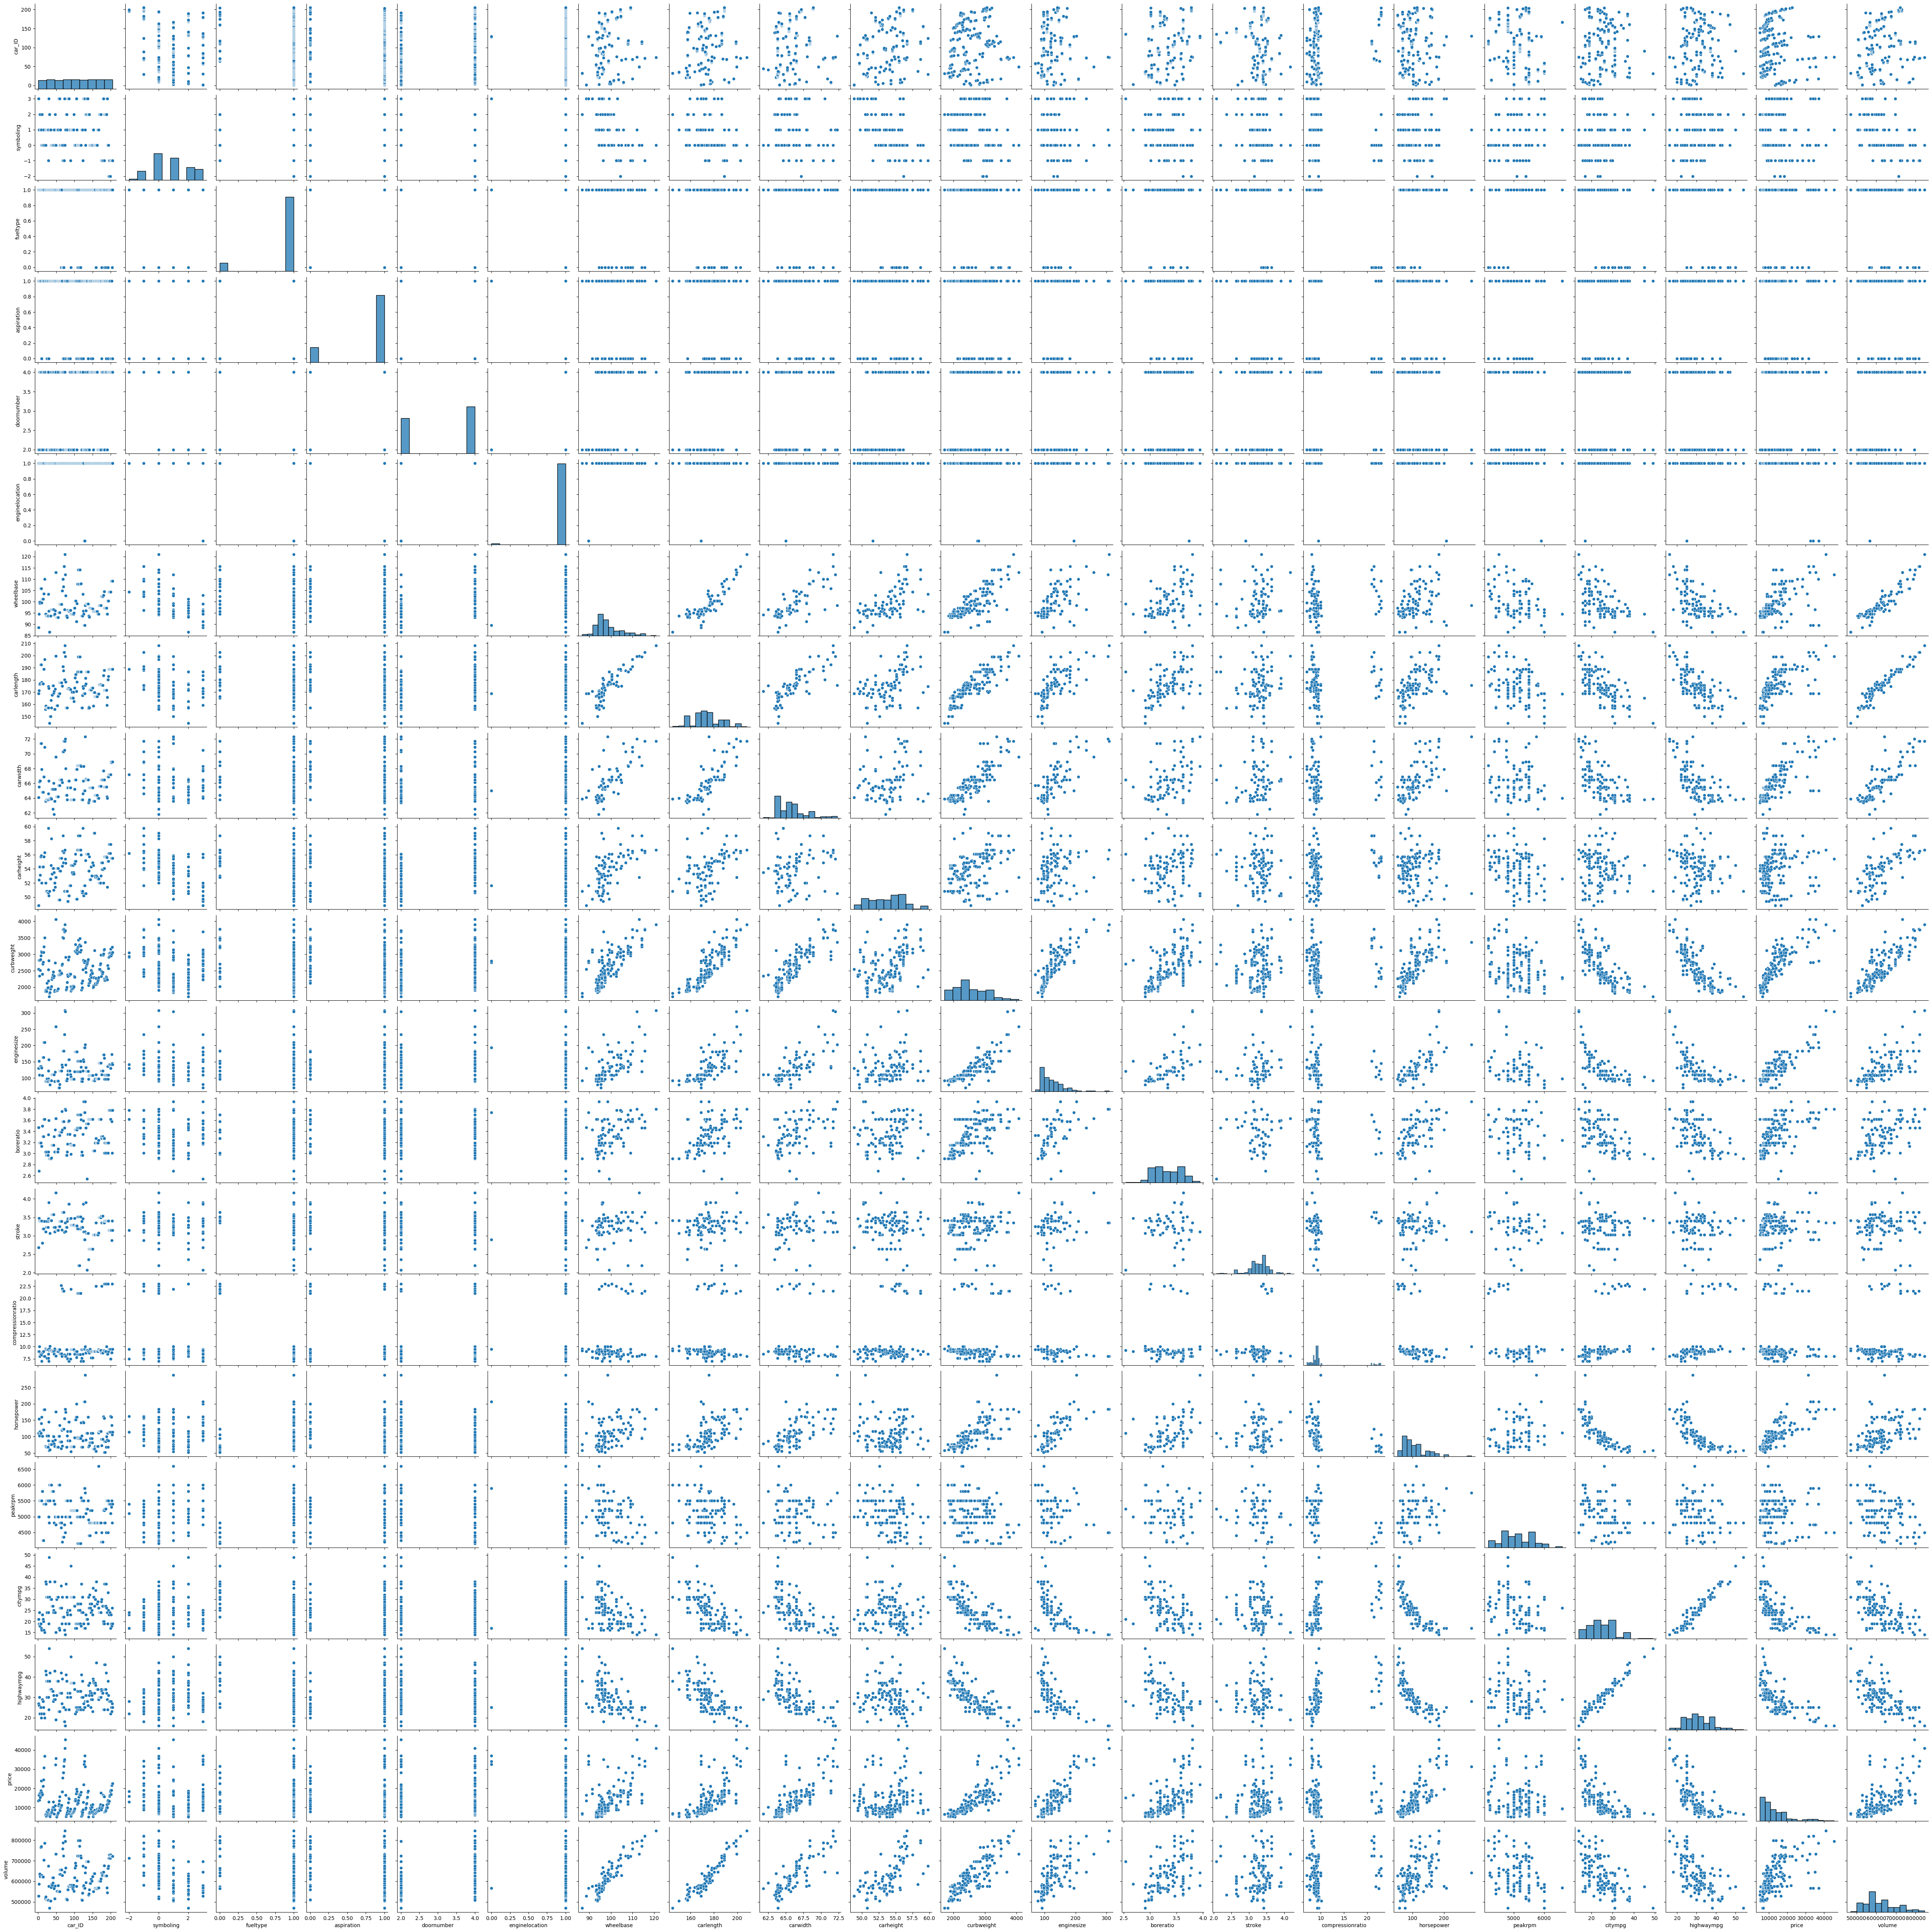

In [14]:
numeric_cols = arjun_df.select_dtypes(exclude=['object']).columns
sns.pairplot(arjun_df[numeric_cols]);

In [15]:
## One hot encoding categorical variables
arjun_df = pd.get_dummies(arjun_df, columns=['drivewheel', 
                                             #'carbody', 
                                             'enginetype', 
                                             'cylindernumber', 
                                             'fuelsystem', 
                                             'country'],drop_first=True,dtype=float)

# arjun_df['is_4_or_6_cyl'] = [1 if x in ['four', 'six'] else 0 for x in arjun_df['cylindernumber']]
# arjun_df['is_5_cyl'] = [1 if x in ['five'] else 0 for x in arjun_df['cylindernumber']]
# arjun_df['is_2_cyl'] = [1 if x in ['two'] else 0 for x in arjun_df['cylindernumber']]

# remove unecessary columns
arjun_df.drop(['car_ID', 'CarName', 'brand'], axis=1, inplace=True)


In [16]:
print(arjun_df.columns)

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'enginelocation',
       'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'volume', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'country_Germany',
       'country_Italy', 'country_Japan', 'country_Sweden', 'country_UK',
       'country_USA'],
      dtype='object')


/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/2063447992.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


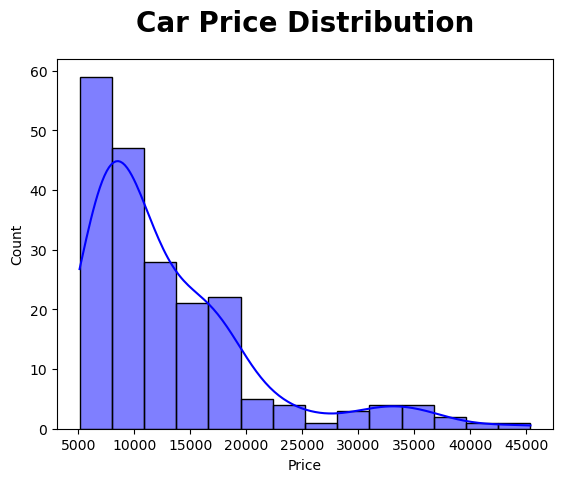

In [17]:
# Dist of Price
sns.histplot(arjun_df["price"], kde=True, color='blue', palette="set1")  # Use histplot for better control
plt.xlabel("Price")
plt.title("Car Price Distribution", fontweight="black", pad=20, fontsize=20)

plt.show()

/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/3588733800.py:16: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


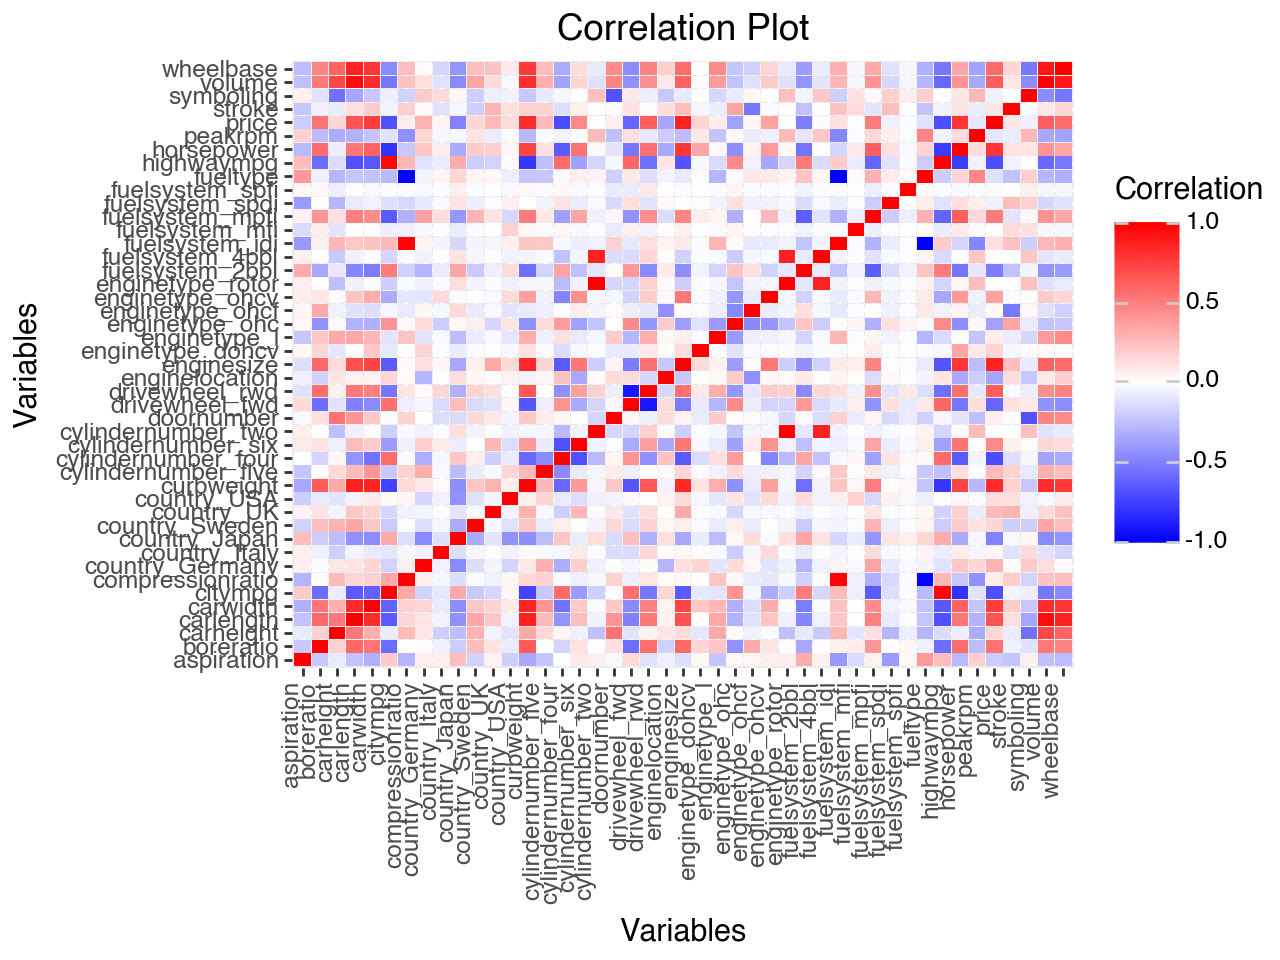

In [18]:
corr_df = arjun_df.copy()
numeric_cols = corr_df.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

corr_melted = corr_matrix.reset_index().melt(id_vars='index')
corr_melted.columns = ['Variable1', 'Variable2', 'Correlation']

corr_plot = (
    ggplot(corr_melted, aes('Variable1', 'Variable2', fill='Correlation'))
    + geom_tile(aes(width=0.95, height=0.95))
    + scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0)
    + labs(title='Correlation Plot', x='Variables', y='Variables', fill='Correlation')
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)

print(corr_plot)

In [19]:
threshold = 0.7

# Get pairs of highly correlated columns
high_corr = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1)]

# Extract column names with high correlations
high_corr_columns = high_corr.stack().index.tolist()

# Convert to a DataFrame for better visualization (optional)
high_corr_df = high_corr.stack().reset_index()
high_corr_df.columns = ['Column 1', 'Column 2', 'Correlation']

filtered = high_corr_df[high_corr_df['Column 1'] == 'doornumber']

# Display the result
print(high_corr_df.sort_values(by='Correlation', ascending=False))

            Column 1          Column 2  Correlation
31  compressionratio    fuelsystem_idi     0.985611
61    fuelsystem_idi  compressionratio     0.985611
39           citympg        highwaympg     0.968970
42        highwaympg           citympg     0.968970
9          carlength            volume     0.952415
..               ...               ...          ...
54    drivewheel_rwd    drivewheel_fwd    -0.910427
30  compressionratio          fueltype    -0.985611
0           fueltype  compressionratio    -0.985611
1           fueltype    fuelsystem_idi    -1.000000
60    fuelsystem_idi          fueltype    -1.000000

[62 rows x 3 columns]


In [20]:
dropped_df = arjun_df.copy()
print("All Columns:\n",dropped_df.columns)

print("-------------------------------------------------------------------------")

dropped_df.drop(['highwaympg', 'wheelbase', 'fueltype', 'curbweight', 'compressionratio',
                'horsepower', 'carwidth', 'carlength', 'carheight', 'boreratio', 'stroke'], axis=1, inplace=True)


print("New Columns:\n",dropped_df.columns)



All Columns:
 Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'enginelocation',
       'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'volume', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'country_Germany',
       'country_Italy', 'country_Japan', 'country_Sweden', 'country_UK',
       'country_USA'],
      dtype='object')
-------------------------------------------------------------------------
New Columns:
 Index(['symboling', 'aspiration', 'doornumber', 'enginelocat

In [21]:
corr_df = dropped_df.copy()
numeric_cols = corr_df.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

corr_melted = corr_matrix.reset_index().melt(id_vars='index')

threshold = 0.7

# Get pairs of highly correlated columns
high_corr = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix != 1)]

# Extract column names with high correlations
high_corr_columns = high_corr.stack().index.tolist()

# Convert to a DataFrame for better visualization (optional)
high_corr_df = high_corr.stack().reset_index()
high_corr_df.columns = ['Column 1', 'Column 2', 'Correlation']

filtered = high_corr_df[high_corr_df['Column 1'] == 'doornumber']

# Display the result
print("New Correlations:\n", high_corr_df.sort_values(by='Correlation', ascending=False))

New Correlations:
               Column 1             Column 2  Correlation
0           enginesize                price     0.874417
1                price           enginesize     0.874417
5     enginetype_rotor      fuelsystem_4bbl     0.863847
7   cylindernumber_two      fuelsystem_4bbl     0.863847
8      fuelsystem_4bbl     enginetype_rotor     0.863847
9      fuelsystem_4bbl   cylindernumber_two     0.863847
2                price  cylindernumber_four    -0.704127
6  cylindernumber_four                price    -0.704127
3       drivewheel_fwd       drivewheel_rwd    -0.910427
4       drivewheel_rwd       drivewheel_fwd    -0.910427


In [22]:
dropped_df.head(5)

,symboling,aspiration,doornumber,enginelocation,enginesize,peakrpm,citympg,price,volume,drivewheel_fwd,...,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,country_Germany,country_Italy,country_Japan,country_Sweden,country_UK,country_USA
0,3,1,2,1,130,5000,21,13495.0,528019.904,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,2,1,130,5000,21,16500.0,528019.904,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,2,1,152,5000,19,16500.0,587592.640,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,1,4,1,109,5500,24,13950.0,634816.956,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2,1,4,1,136,5500,18,17450.0,636734.832,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
arjun_df.head()

,symboling,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,country_Germany,country_Italy,country_Japan,country_Sweden,country_UK,country_USA
0,3,1,1,2,1,88.6,168.8,64.1,48.8,2548,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,1,2,1,88.6,168.8,64.1,48.8,2548,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,1,1,2,1,94.5,171.2,65.5,52.4,2823,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,1,1,4,1,99.8,176.6,66.2,54.3,2337,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2,1,1,4,1,99.4,176.6,66.4,54.3,2824,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = dropped_df.drop(['price'], axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical features
X_encoded = sm.add_constant(X_encoded)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_encoded.columns
vif_data['VIF'] = [variance_inflation_factor(X_encoded.values, i) for i in range(X_encoded.shape[1])]
print(vif_data)

                Feature          VIF
0                 const  2798.775900
1             symboling     3.245495
2            aspiration     2.489702
3            doornumber     2.584708
4        enginelocation     2.396418
5            enginesize    15.280761
6               peakrpm     3.512499
7               citympg     7.462751
8                volume     8.580830
9        drivewheel_fwd     8.323307
10       drivewheel_rwd    11.014111
11     enginetype_dohcv     1.819026
12         enginetype_l    10.391195
13       enginetype_ohc     9.970917
14      enginetype_ohcf     5.177896
15      enginetype_ohcv     3.478961
16     enginetype_rotor          inf
17  cylindernumber_five    11.958592
18  cylindernumber_four    44.240487
19   cylindernumber_six    15.158593
20   cylindernumber_two          inf
21      fuelsystem_2bbl     6.866177
22      fuelsystem_4bbl     4.558890
23       fuelsystem_idi     6.527923
24       fuelsystem_mfi     1.363551
25      fuelsystem_mpfi    10.326849
2

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars


In [25]:
# Dropping features with infinite VIF and high VIF values to reduce multicollinearity
X_encoded = X_encoded.drop(['cylindernumber_two', 'enginetype_rotor', 'country_Japan', 'enginesize'], axis=1)

# Recalculate VIF after dropping high VIF features
vif_data = pd.DataFrame()


columns_to_use = X_encoded.columns
vif_data['Feature'] = columns_to_use
vif_data['VIF'] = [variance_inflation_factor(X_encoded.values, i) for i in range(X_encoded.shape[1])]

print(vif_data)


                Feature          VIF
0                 const  1959.639054
1             symboling     3.093180
2            aspiration     2.468506
3            doornumber     2.554264
4        enginelocation     2.107685
5               peakrpm     3.092902
6               citympg     6.388578
7                volume     6.754233
8        drivewheel_fwd     8.129230
9        drivewheel_rwd     9.745500
10     enginetype_dohcv     1.494620
11         enginetype_l     3.804936
12       enginetype_ohc     9.676452
13      enginetype_ohcf     5.125719
14      enginetype_ohcv     2.780800
15  cylindernumber_five     6.352480
16  cylindernumber_four    19.730605
17   cylindernumber_six     7.628052
18      fuelsystem_2bbl     6.408211
19      fuelsystem_4bbl     2.695832
20       fuelsystem_idi     5.962103
21       fuelsystem_mfi     1.336545
22      fuelsystem_mpfi     9.699978
23      fuelsystem_spdi     2.694762
24      fuelsystem_spfi     1.194701
25      country_Germany     3.052139
2

In [26]:
modeling_cols = ['symboling', 'aspiration', 'doornumber', 'enginelocation', 'peakrpm',
       'citympg', 'volume', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'country_Germany',
       'country_Italy', 'country_Sweden', 'country_UK', 'country_USA', 'price']
dropped_df = dropped_df[modeling_cols]
dropped_df.head()

,symboling,aspiration,doornumber,enginelocation,peakrpm,citympg,volume,drivewheel_fwd,drivewheel_rwd,enginetype_dohcv,...,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,country_Germany,country_Italy,country_Sweden,country_UK,country_USA,price
0,3,1,2,1,5000,21,528019.904,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13495.0
1,3,1,2,1,5000,21,528019.904,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16500.0
2,1,1,2,1,5000,19,587592.640,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16500.0
3,2,1,4,1,5500,24,634816.956,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13950.0
4,2,1,4,1,5500,18,636734.832,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17450.0


In [27]:
df_for_regularization = arjun_df.copy()

In [28]:
response_variable = 'price'
predictors = arjun_df.columns.drop(response_variable)

formula_predictors = f"{response_variable} ~ " + " + ".join(predictors)
model_test = smf.ols(formula=formula_predictors, data=arjun_df).fit()

model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     69.79
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           6.07e-83
Time:                        08:23:52   Log-Likelihood:                -1791.8
No. Observations:                 202   AIC:                             3670.
Df Residuals:                     159   BIC:                             3812.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            7.199e+04   5.35e+04      1.345      0.181   -3.38e+04    1.78e+05
symboling              89.5760    233.761      0.383      0.702    -372.100     551.252
fueltype             3.298e+04    2.7e+04      1.222      0.223   -2.03e+04    8.63e+04
aspiration          -1770.3552    852.166     -2.077      0.039   -3453.380     -87.330
doornumber            281.2760    234.981      1.197      0.233    -182.811     745.363
enginelocation      -9794.5521   2227.969     -4.396      0.000   -1.42e+04   -5394.321
wheelbase              68.4035     94.948      0.720      0.472    -119.119     255.926
carlength            -436.9925    220.932     -1.978      0.050    -873.332      -0.653
carwidth             -309.8637    638.852     -0.485      0.628   -1571.594     951.867
carheight           -1063.4270    704.795     -1.509      0.133   -2455.395     328.541
curbweight              3.7407      1.503      2.489      0.014       0.773       6.709
enginesize             71.6795     26.078      2.749      0.007      20.175     123.184
boreratio             885.5734   1651.686      0.536      0.593   -2376.500    4147.647
stroke              -4117.9278    883.232     -4.662      0.000   -5862.307   -2373.549
compressionratio     -359.9068    476.702     -0.755      0.451   -1301.391     581.578
horsepower             20.7430     21.794      0.952      0.343     -22.301      63.787
peakrpm                 1.4878      0.618      2.408      0.017       0.268       2.708
citympg              -133.8107    138.171     -0.968      0.334    -406.698     139.077
highwaympg            127.4986    122.509      1.041      0.300    -114.455     369.452
volume                  0.0993      0.062      1.593      0.113      -0.024       0.222
drivewheel_fwd        308.8551    927.770      0.333      0.740   -1523.488    2141.198
drivewheel_rwd       1408.8886   1084.565      1.299      0.196    -733.122    3550.900
enginetype_dohcv     -1.22e+04   4383.192     -2.784      0.006   -2.09e+04   -3547.484
enginetype_l        -2138.5536   2286.187     -0.935      0.351   -6653.765    2376.658
enginetype_ohc       2755.9338   1085.186      2.540      0.012     612.696    4899.172
enginetype_ohcf      -257.9280   1420.416     -0.182      0.856   -3063.245    2547.389
enginetype_ohcv     -3955.5769   1167.451     -3.388      0.001   -6261.289   -1649.865
enginetype_rotor    -3370.0333   2225.226     -1.514      0.132   -7764.845    1024.779
cylindernumber_five -1.304e+04   2769.664     -4.710      0.000   -1.85e+04   -7574.161
cylindernumber_four -1.416e+04   3289.955     -4.305      0.000   -2.07e+04   -7666.247
cylindernumber_six  -1.095e+04   2240.072     -4.890      0.000   -1.54e+04   -6529.426
cylindernumber_two  -3370.0333   2225.226     -1.514      0.132   -7764.845    1024.779
fue

Data preprocessing done

## FULL MODEL    

In [29]:
predictors = "+".join([col for col in columns_to_use[1:] if col not in ['price', 'peakrpm', 'doornumber']])

In [30]:
# regressing preprocessed data on all predictors
all_regress=smf.ols('price ~ '+ predictors, data=dropped_df).fit()
all_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     57.65
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           1.13e-72
Time:                        08:23:52   Log-Likelihood:                -1859.5
No. Observations:                 202   AIC:                             3775.
Df Residuals:                     174   BIC:                             3868.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.967e+04   5255.350      3.743      0.000    9296.716       3e+04
symboling             406.3839    211.506      1.921      0.056     -11.064     823.832
aspiration          -2480.4587    730.832     -3.394      0.001   -3922.895   -1038.022
enginelocation      -1.428e+04   2088.717     -6.835      0.000   -1.84e+04   -1.02e+04
citympg              -109.4887     72.071     -1.519      0.131    -251.735      32.757
volume                  0.0368      0.005      6.718      0.000       0.026       0.048
drivewheel_fwd        528.9241   1055.318      0.501      0.617   -1553.949    2611.797
drivewheel_rwd       4424.8707   1165.143      3.798      0.000    2125.238    6724.503
enginetype_dohcv     1799.0515   3158.498      0.570      0.570   -4434.849    8032.952
enginetype_l        -1073.1145   1528.877     -0.702      0.484   -4090.646    1944.417
enginetype_ohc       3099.8915   1127.167      2.750      0.007     875.212    5324.571
enginetype_ohcf      3354.1130   1388.917      2.415      0.017     612.819    6095.407
enginetype_ohcv      1781.2977   1273.887      1.398      0.164    -732.963    4295.558
cylindernumber_five -1.236e+04   1944.455     -6.355      0.000   -1.62e+04   -8519.577
cylindernumber_four -1.581e+04   1931.172     -8.187      0.000   -1.96e+04    -1.2e+04
cylindernumber_six  -1.076e+04   1579.407     -6.811      0.000   -1.39e+04   -7639.767
fuelsystem_2bbl     -1717.9498    880.788     -1.950      0.053   -3456.353      20.454
fuelsystem_4bbl      -1.48e+04   2464.864     -6.006      0.000   -1.97e+04   -9939.584
fuelsystem_idi      -1210.3610   1301.722     -0.930      0.354   -3779.559    1358.837
fuelsystem_mfi      -2144.1830   2954.260     -0.726      0.469   -7974.980    3686.614
fuelsystem_mpfi     -1487.0367   1052.602     -1.413      0.160   -3564.548     590.475
fuelsystem_spdi     -1772.0951   1414.318     -1.253      0.212   -4563.522    1019.332
fuelsystem_spfi     -3037.4262   2807.477     -1.082      0.281   -8578.520    2503.668
country_Germany      1613.1115    807.860      1.997      0.047      18.646    3207.577
country_Italy        4308.4372   1762.666      2.444      0.016     829.479    7787.396
country_Sweden        162.9887    917.661      0.178      0.859   -1648.192    1974.169
country_UK           1.347e+04   2134.321      6.312      0.000    9260.225    1.77e+04
country_USA          1557.0983    671.450      2.319      0.022     231.863    2882.334
==============================================================================
Omnibus:                       21.037   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.991
Skew:                           0.351   Prob(JB):                     5.70e-14
Kurtosis:                       5.599  

In [31]:
p = len([col for col in dropped_df.columns if col != 'price'])
n = len(dropped_df)

ols_mse = (all_regress.resid ** 2).sum() / (n - (p+1))
ols_aic = all_regress.aic
ols_bic = all_regress.bic
ols_adjusted_r2 = all_regress.rsquared_adj

print(ols_mse, ols_aic, ols_bic, ols_adjusted_r2)

6806059.658852104 3774.906404581383 3867.5379001086167 0.8838447206870995


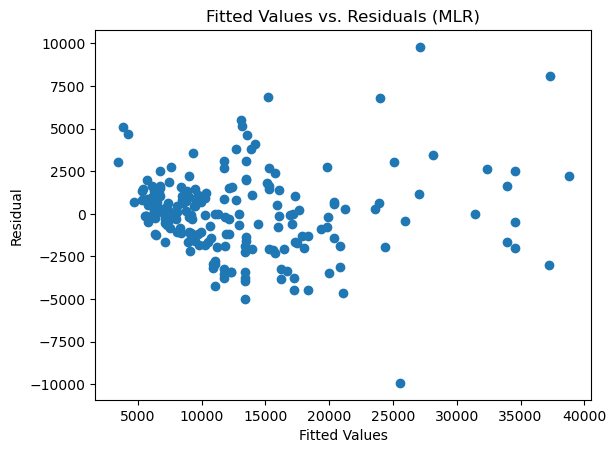

In [32]:
y = dropped_df['price']

fitted_values = all_regress.fittedvalues
residuals = all_regress.resid

p = (fitted_values)
res = y.values-fitted_values

plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals (MLR)") # fitting regreesion and look at residuals
plt.show()

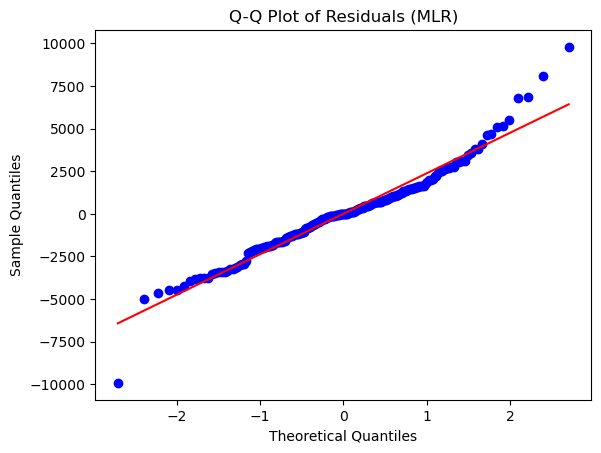

In [33]:
fitted_values = all_regress.fittedvalues
residuals = all_regress.resid

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (MLR)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

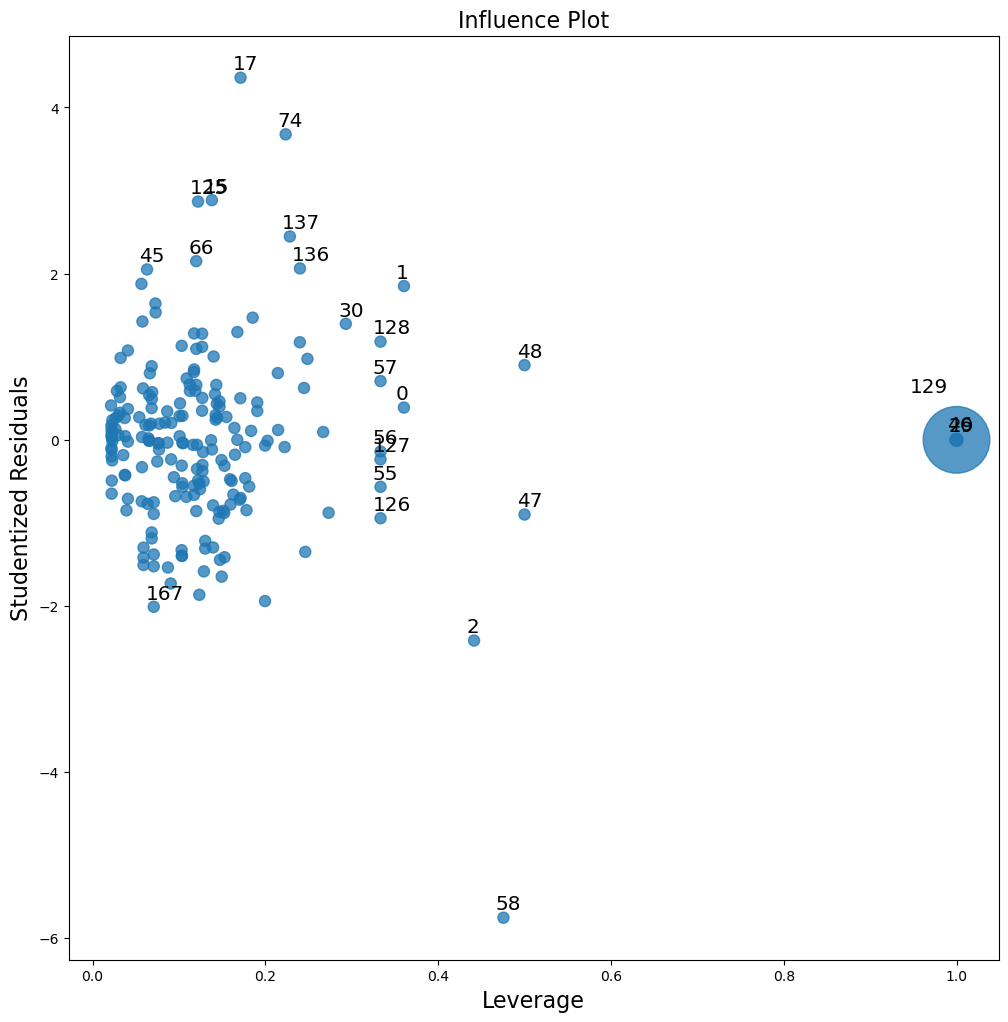

In [34]:
#graphical representation of the influence of each observation
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(all_regress, ax=ax, criterion="cooks") 
plt.show()
#size of points are given by cook's dist value
#the points with massive size whose studentized resids lie outside the range from (-3,3) should raise a "yellow" flag

In [35]:
print('AIC', ols_aic)
print('BIC', ols_bic)

AIC 3774.906404581383
BIC 3867.5379001086167


## RIDGE

In [36]:
# Standardizing the data
temp_ridge=df_for_regularization.copy()

y = temp_ridge['price']
scaler = StandardScaler()
standardized_data = scaler.fit_transform(temp_ridge)
df_standardized = pd.DataFrame(standardized_data, columns=temp_ridge.columns)

X = df_standardized.drop('price', axis=1)

# Fit Ridge model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

# Get fitted values and residuals
y_fitted_ridge = ridge_model.predict(X)
residuals = y - y_fitted_ridge

# Compute the Mean Squared Error
ridge_mse = mean_squared_error(y, y_fitted_ridge)
print("Mean Squared Error:", ridge_mse)

# Now calculate p-values
n = X.shape[0]  # number of observations
p = X.shape[1]  # number of predictors
df_residuals = n - p - 1  # degrees of freedom

# Variance of the residuals
residual_var = np.var(residuals, ddof=p+1)

# Compute the standard error of the coefficients
X_design = np.hstack([np.ones((X.shape[0], 1)), X])  # Add intercept to design matrix
XtX_inv = np.linalg.inv(X_design.T @ X_design)  # Inverse of (X^T * X)
standard_errors = np.sqrt(np.diag(XtX_inv) * residual_var)

# Compute t-statistics for each coefficient
t_stats = ridge_model.coef_ / standard_errors[1:]  # Omit the intercept's SE

# Compute p-values for each coefficient
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_residuals))

# Print results
print(f"Intercept: {ridge_model.intercept_}")
for i in range(len(ridge_model.coef_)):
    print(f"Predictor {X.columns[i]} Coefficient: {ridge_model.coef_[i]} | p-value: {p_values[i]}")


Mean Squared Error: 3060834.674833971
Intercept: 13065.641915841581
Predictor symboling Coefficient: 77.52338873707247 | p-value: 0.7117736331397371
Predictor fueltype Coefficient: -505.07774299739015 | p-value: nan
Predictor aspiration Coefficient: -746.8741337865569 | p-value: 0.00025187845488860994
Predictor doornumber Coefficient: 286.2691386176271 | p-value: nan
Predictor enginelocation Coefficient: -1276.7163400804654 | p-value: 1.5133188702165512e-07
Predictor wheelbase Coefficient: 627.4524050862453 | p-value: 0.22249291145401595
Predictor carlength Coefficient: -1394.9876969815723 | p-value: 0.5837069686235075
Predictor carwidth Coefficient: 1200.6268539706725 | p-value: 0.36245559034950925
Predictor carheight Coefficient: -199.1221214150135 | p-value: 0.9050688197824803
Predictor curbweight Coefficient: 1680.317626561806 | p-value: 0.0058691548528952975
Predictor enginesize Coefficient: 3722.77164818854 | p-value: 8.553011561263091e-05
Predictor boreratio Coefficient: -130.04

/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/696858651.py:34: RuntimeWarning: invalid value encountered in sqrt


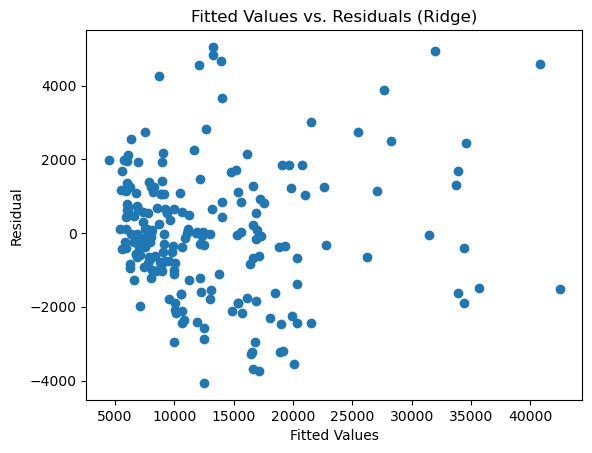

In [37]:
y = temp_ridge['price']

p = (y_fitted_ridge)
res = y.values-y_fitted_ridge

plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals (Ridge)") # fitting regreesion and look at residuals
plt.show()

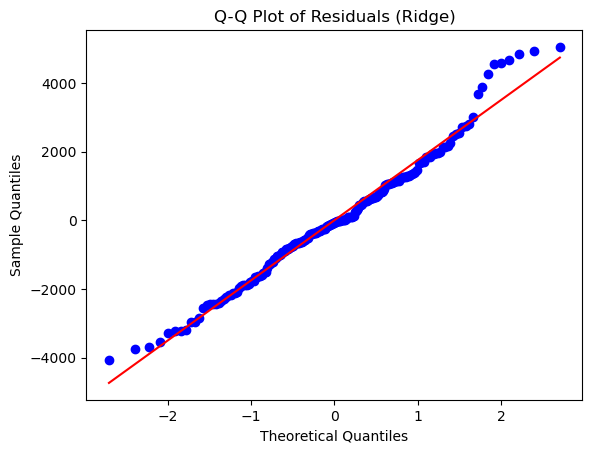

In [38]:
#rigde qq plot
stats.probplot(res, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Ridge)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [39]:
ridge_mse = mean_squared_error(y, y_fitted_ridge)
# Get number of observations and number of parameters
n = df_standardized.shape[0]  # Number of observations
k = np.sum(ridge_model.coef_ != 0) + 1  # Number of predictors (non-zero coefficients + intercept)
# Calculate AIC and BIC
ridge_aic = n * np.log(ridge_mse) + 2 * k
ridge_bic = n * np.log(ridge_mse) + np.log(n) * k
# Calculate R-squared and Adjusted R-squared
ridge_r_squared = r2_score(y, y_fitted_ridge)
ridge_adjusted_r_squared = 1 - (1 - ridge_r_squared) * (n - 1) / (n - k)
# Print results
print(f"AIC: {ridge_aic:.2f}")
print(f"BIC: {ridge_bic:.2f}")
print(f"R-squared: {ridge_r_squared:.4f}")
print(f"Adjusted R-squared: {ridge_adjusted_r_squared:.4f}")

AIC: 3106.71
BIC: 3255.58
R-squared: 0.9469
Adjusted R-squared: 0.9320


## LASSO

In [40]:
temp = df_for_regularization.copy()

In [41]:
# Create a copy of the DataFrame and drop the target variable
temp = df_for_regularization.copy()
temp.drop(['price'], axis=1, inplace=True)

# Convert target variable to a NumPy array
arr = np.array(df_for_regularization['price'])
reshaped_arr = arr.reshape(-1)  # Reshape to a 1D array

# Standardize the features
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp)

# Fit Lasso model
lasso = Lasso(alpha=0.2, max_iter=10000, tol=0.03)
lasso.fit(temp_scaled, reshaped_arr)

# Predictions and residuals
predictions = lasso.predict(temp_scaled)
residuals = reshaped_arr - predictions

# Calculate mean squared error
lasso_mse = mean_squared_error(reshaped_arr, predictions)
print(f"Mean Squared Error: {lasso_mse}")

n = temp_scaled.shape[0]
p = temp_scaled.shape[1]
# df
df_residuals = n - p - 1

residual_var = np.var(residuals, ddof=p+1)

# get SE's of coefficients
X_design = np.hstack([np.ones((temp_scaled.shape[0], 1)), temp_scaled])  # Add intercept
XtX_inv = np.linalg.inv(X_design.T @ X_design)  # Inverse of (X^T * X)
standard_errors = np.sqrt(np.diag(XtX_inv) * residual_var)

# get t-statistics for each coefficient
t_stats = lasso.coef_ / standard_errors[1:]

# get p-values for each coefficient
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_residuals))

print(f"Intercept: {lasso.intercept_}")
for i in range(len(lasso.coef_)):
    print(f"Predictor {temp.columns[i]} Coefficient: {lasso.coef_[i]} | p-value: {p_values[i]}")


Mean Squared Error: 3448576.6149535775
Intercept: 13065.641915841577
Predictor symboling Coefficient: 408.19608629838257 | p-value: 0.06822740993176879
Predictor fueltype Coefficient: -612.263407110036 | p-value: nan
Predictor aspiration Coefficient: -973.7181658320441 | p-value: 8.614569130704908e-06
Predictor doornumber Coefficient: 286.6737246886308 | p-value: nan
Predictor enginelocation Coefficient: -1869.6454415043709 | p-value: 2.7045032879868813e-12
Predictor wheelbase Coefficient: 1483.1472083601655 | p-value: 0.007108892914151177
Predictor carlength Coefficient: 1517.6058223016032 | p-value: 0.5743760877597583
Predictor carwidth Coefficient: 2284.0759875955746 | p-value: 0.10363801864364608
Predictor carheight Coefficient: 991.6725294155094 | p-value: 0.5759620702960384
Predictor curbweight Coefficient: 2152.3701346846674 | p-value: 0.0009437407961221389
Predictor enginesize Coefficient: 3761.870542860965 | p-value: 0.00017811428745351243
Predictor boreratio Coefficient: -335

/var/folders/tv/c30xlnzn0pl1tm718pxcwh8h0000gn/T/ipykernel_73254/266651226.py:35: RuntimeWarning: invalid value encountered in sqrt


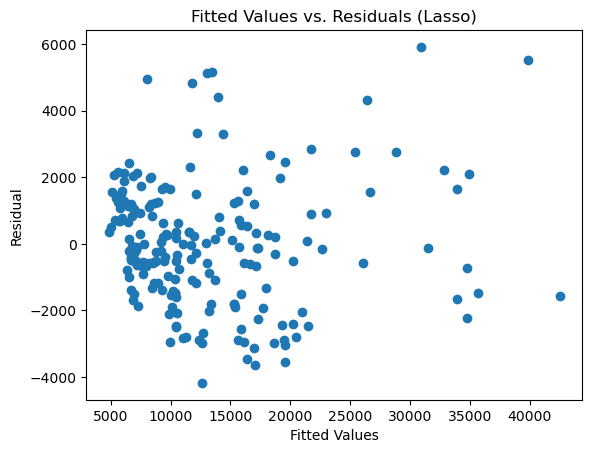

In [42]:
p = predictions
res = reshaped_arr-predictions
plt.scatter(p,res)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals (Lasso)") # fitting regreesion and look at residuals
plt.show()

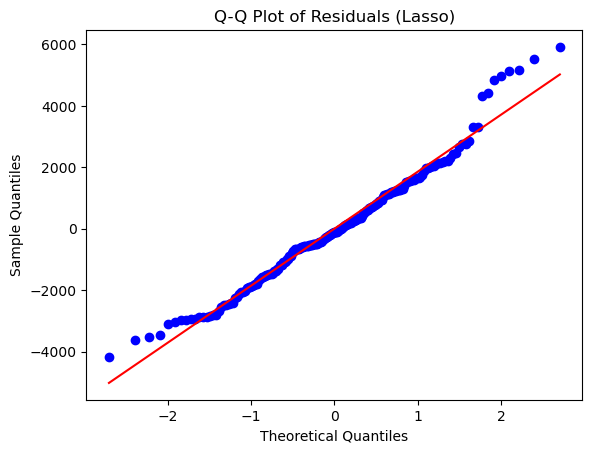

In [43]:
residuals = reshaped_arr - predictions

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Lasso)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [46]:
# Get number of observations and number of parameters
n = temp_scaled.shape[0]  # Number of observations
k = np.sum(lasso.coef_ != 0) + 1  # Number of predictors (non-zero coefficients + intercept)
# Calculate AIC and BIC
lasso_aic = n * np.log(lasso_mse) + 2 * k
lasso_bic = n * np.log(lasso_mse) + np.log(n) * k
# Calculate R-squared and Adjusted R-squared
lasso_r_squared = r2_score(reshaped_arr, predictions)
lasso_adjusted_r_squared = 1 - (1 - lasso_r_squared) * (n - 1) / (n - k)

# print(f"intercept: {lasso.intercept_}")
# for i in range(len(lasso.coef_)):
#     print(f"Predictor {X.columns[i]} has value of ({lasso.coef_[i]})")
print('----------------------------------')
# Print results
print(f"AIC: {lasso_aic:.2f}")
print(f"BIC: {lasso_bic:.2f}")
print(f"R-squared: {lasso_r_squared:.4f}")
print(f"Adjusted R-squared: {lasso_adjusted_r_squared:.4f}")

----------------------------------
AIC: 3130.80
BIC: 3279.67
R-squared: 0.9402
Adjusted R-squared: 0.9234


## RESULTS

In [45]:
results_df = pd.DataFrame({
    "Model": ['OLS', 'Lasso', 'Ridge'],
    'AIC': [ols_aic, lasso_aic, ridge_aic],
    'BIC': [ols_bic, lasso_bic, ridge_bic],
    'MSE': [ols_mse, lasso_mse, ridge_mse],
    'Adjusted R2': [ols_adjusted_r2, lasso_adjusted_r_squared, ridge_adjusted_r_squared]
})

results_df

,Model,AIC,BIC,MSE,Adjusted R2
0,OLS,3774.906405,3867.537900,6.806060e+06,0.883845
1,Lasso,3130.801370,3279.673416,3.448577e+06,0.923395
2,Ridge,3106.708038,3255.580084,3.060835e+06,0.932008
